In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.core.display import display, HTML
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import pandas as pd
import json, sys, re, os

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.max_open_warning'] = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.insert(0, os.getcwd() + "/../../")
from analysis.utils import PM_HOME, GPU_NAME, CPU_EVENT_OVERHEAD, GPU_EVENT_OVERHEAD, KERNEL_LAUNCH_LENGTH
from analysis.trace_utils import *

In [2]:
# %%capture
model_name = "DLRM_default" # "DLRM_MLPerf"
num_gpus = 1
batch_size = 2048
iters = 10
module_marker = "DLRM " if "DLRM" in model_name else "## Forward ##"

trace_file = '{}/data/{}/e2e/{}/{}_{}.json'.format(PM_HOME, GPU_NAME, model_name, num_gpus, batch_size)

trimmed_trace_file = trim_trace_by_num_iter(trace_file, iters=iters, trimmed_file='/tmp/{}_{}_{}'.format(model_name, num_gpus, batch_size))
with open(trimmed_trace_file) as f:
    trace = json.load(f)

## DLRM with data loading

In [3]:
roots, cc, corrected_start_time, corrected_end_time, sum_skipped_intervals = process_event_hierarchy(trace['traceEvents'], skip_module=False, module_marker=module_marker)
print('Num of events: {}, num of root events: {}, num of caller/callee pairs: {}'.format(len(trace['traceEvents']), len(roots), len(cc)))
print('Sum of dataloading time: {}'.format(sum_skipped_intervals))
print("Corrected start time: ", corrected_start_time, ", corrected end time: ", corrected_end_time)
host_runtime = corrected_end_time - corrected_start_time - sum_skipped_intervals
# ---
# device_runtime, device_start_delay = get_device_runtime_and_start_delay(cc, corrected_start_time)
# print("Device start delay: ", device_start_delay)
# ---
device_runtime = host_runtime
# ---
print("Host runtime: ", host_runtime)
print("Device runtime: ", device_runtime)
ops = []
get_operators(roots, ops)
QPS = 1000000 / host_runtime * iters * 2048
print(f"QPS: {QPS:.2f}")

Num of events: 12730, num of root events: 150, num of caller/callee pairs: 4769
Sum of dataloading time: 383518
Corrected start time:  1628563022525616 , corrected end time:  1628563023018701
Host runtime:  109567
Device runtime:  109567
QPS: 186917.59


### Host runtime breakdown

In [4]:
depth_limit = 3
truncate_count = 3
host_runtime_breakdown = get_host_runtime_breakdown(roots, cc, host_runtime)
print_host_results(host_runtime_breakdown, depth_limit, truncate_count)

Two iteration runtime:               109567 (in us, same below)
     DLRM backward:                             (58382.0, 53.28%, 10)
          IndexBackward:                                  (11262.0, 19.29%, 10)
               aten::_index_put_impl_:                              (10615.0, 94.26%, 10)
                    aten::to:                                                  (7236.0, 68.17%, 20)
                    aten::contiguous:                                           (458.0, 4.31%, 10)
                    aten::arange:                                               (447.0, 4.21%, 10)
                    Others:                                                    (1593.0, 15.01%)
                    Unaccounted:                                                (881.0, 8.30%)
               aten::new_zeros:                                       (520.0, 4.62%, 10)
                    aten::zeros:                                                (469.0, 90.19%, 10)
                  

In [5]:
op_device_runtime = get_device_runtime(ops, cc) # dict: op ex_id -> all its device calls and stats
pprint(op_device_runtime)

{32953: {7: {('Memcpy HtoD (Pinned -> Device)', (-1,)): {'count': 1,
                                                         'runtime': 528.0}}},
 32956: {7: {('Memcpy HtoD (Pinned -> Device)', (-1,)): {'count': 1,
                                                         'runtime': 7.0}}},
 32959: {7: {('Memcpy HtoD (Pinned -> Device)', (-1,)): {'count': 1,
                                                         'runtime': 340.0}}},
 32967: {7: {('unrolled_elementwise_kernel', (-1,)): {'count': 1,
                                                      'runtime': 13.0},
             ('volta_sgemm_128x64_tn', (-1,)): {'count': 1, 'runtime': 123.0}}},
 32974: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 12.0}}},
 32979: {7: {('unrolled_elementwise_kernel', (-1,)): {'count': 1,
                                                      'runtime': 5.0},
             ('volta_sgemm_64x32_sliced1x4_tn', (-1,)): {'cou

 33712: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('unrolled_elementwise_kernel', (-1,)): {'count': 1,
                                                      'runtime': 18.0},
             ('volta_sgemm_128x64_tn', (-1,)): {'count': 1, 'runtime': 439.0}}},
 33719: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 23.0}}},
 33724: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('unrolled_elementwise_kernel', (-1,)): {'count': 1,
                                                      'runtime': 19.0},
             ('volta_sgemm_128x64_tn', (-1,)): {'count': 1, 'runtime': 436.0}}},
 33731: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 24.0}}},
 33736: {7: {('unrolled_elementwise_kernel', (-1,)): {'count': 1,
                                                      'runtime': 4

 34560: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('reduce_kernel', (-1,)): {'count': 1, 'runtime': 20.0}}},
 34563: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 3.0}}},
 34569: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 4.0}}},
 34578: {7: {('DeviceRadixSortSingleTileKernel', (-1,)): {'count': 1,
                                                          'runtime': 11.0},
             ('Memcpy HtoD (Pageable -> Device)', (-1,)): {'count': 2,
                                                           'runtime': 2.0},
             ('elementwise_kernel_with_index', (-1,)): {'count': 1,
                                                        'runtime': 2.0},
             ('indexing_backward_kernel', (-1,)): {'count': 1, 'runtime': 41.0},
             ('unrolled_elementwise_kernel', (-1,)): {'c

 35343: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 19.0}}},
 35345: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('volta_sgemm_32x128_nt', (-1,)): {'count': 1, 'runtime': 119.0}}},
 35353: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('reduce_kernel', (-1,)): {'count': 1, 'runtime': 13.0}}},
 35356: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 3.0}}},
 35362: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 5.0}}},
 35367: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 12,
                                                        'runtime': 71.0}}},
 35573: {7: {('Memcpy HtoD (Pinned -> Device)', (-1,)): {'count': 1,
                                                         'run

 36435: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 3.0}}},
 36438: {7: {('void gemvNSP_kernel', (-1,)): {'count': 1, 'runtime': 20.0},
             ('void splitKreduce_kernel', (-1,)): {'count': 1, 'runtime': 4.0},
             ('volta_sgemm_128x32_nn', (-1,)): {'count': 1, 'runtime': 18.0}}},
 36450: {7: {('reduce_kernel', (-1,)): {'count': 1, 'runtime': 7.0}}},
 36453: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 3.0}}},
 36459: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 3.0}}},
 36461: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 33.0}}},
 36463: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('volta_sgemm_32x128_nn', (-1,)): {'

 37166: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 35.0}}},
 37168: {7: {('void splitKreduce_kernel', (-1,)): {'count': 1, 'runtime': 7.0},
             ('volta_sgemm_32x128_nt', (-1,)): {'count': 1, 'runtime': 185.0},
             ('volta_sgemm_64x32_sliced1x4_nn', (-1,)): {'count': 1,
                                                         'runtime': 69.0}}},
 37180: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('reduce_kernel', (-1,)): {'count': 1, 'runtime': 19.0}}},
 37183: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 3.0}}},
 37189: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 4.0}}},
 37198: {7: {('DeviceRadixSortSingleTileKernel', (-1,)): {'count': 1,
                                                    

 38276: {7: {('CatArrayBatchedCopy', (-1,)): {'count': 1, 'runtime': 6.0}}},
 38285: {7: {('unrolled_elementwise_kernel', (-1,)): {'count': 1,
                                                      'runtime': 18.0},
             ('volta_sgemm_128x32_tn', (-1,)): {'count': 1, 'runtime': 55.0}}},
 38292: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 24.0}}},
 38297: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('unrolled_elementwise_kernel', (-1,)): {'count': 1,
                                                      'runtime': 18.0},
             ('volta_sgemm_128x64_tn', (-1,)): {'count': 1, 'runtime': 440.0}}},
 38304: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 24.0}}},
 38309: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('unrolled_elementwise_kernel', (-1,)): {'c

 39095: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('reduce_kernel', (-1,)): {'count': 1, 'runtime': 26.0}}},
 39098: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 3.0}}},
 39104: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 17.0}}},
 39106: {7: {('vectorized_elementwise_kernel', (-1,)): {'count': 1,
                                                        'runtime': 35.0}}},
 39108: {7: {('Memset (Device)', (-1,)): {'count': 2, 'runtime': 2.0},
             ('volta_sgemm_32x128_nn', (-1,)): {'count': 1, 'runtime': 392.0},
             ('volta_sgemm_32x128_nt', (-1,)): {'count': 1, 'runtime': 373.0}}},
 39120: {7: {('Memset (Device)', (-1,)): {'count': 1, 'runtime': 1.0},
             ('reduce_kernel', (-1,)): {'count': 1, 'runtime': 23.0}}},
 39123: {7: {('vectorized_elementwise_kernel', (-1,)

In [6]:
print_all_device_results(roots, op_device_runtime, device_runtime, depth=0)

DLRM forward
    aten::to
        Memcpy HtoD (Pinned -> Device):                   ( (-1,), 1, 528.0 )
    aten::to
        Memcpy HtoD (Pinned -> Device):                   ( (-1,), 1, 7.0 )
    aten::to
        Memcpy HtoD (Pinned -> Device):                   ( (-1,), 1, 340.0 )
    module::forward_pass::bottom_mlp
        aten::linear
            unrolled_elementwise_kernel:                          ( (-1,), 1, 13.0 )
            volta_sgemm_128x64_tn:                                ( (-1,), 1, 123.0 )
        aten::relu
            vectorized_elementwise_kernel:                        ( (-1,), 1, 12.0 )
        aten::linear
            unrolled_elementwise_kernel:                          ( (-1,), 1, 5.0 )
            volta_sgemm_64x32_sliced1x4_tn:                       ( (-1,), 1, 31.0 )
        aten::relu
            vectorized_elementwise_kernel:                        ( (-1,), 1, 3.0 )
    module::forward_pass::embedding_lookup
        LookupFunction
            void batched

        elementwise_kernel_with_index:                    ( (-1,), 1, 2.0 )
        DeviceRadixSortSingleTileKernel:                  ( (-1,), 1, 11.0 )
        indexing_backward_kernel:                         ( (-1,), 1, 41.0 )
    SliceBackward
        vectorized_elementwise_kernel:                    ( (-1,), 1, 3.0 )
        Memcpy DtoD (Device -> Device):                   ( (-1,), 1, 4.0 )
    BmmBackward0
        volta_sgemm_32x128_nt:                            ( (-1,), 1, 49.0 )
        void gemmSN_NN_kernel:                            ( (-1,), 1, 35.0 )
    aten::add
        unrolled_elementwise_kernel:                      ( (-1,), 1, 28.0 )
    aten::add
        unrolled_elementwise_kernel:                      ( (-1,), 1, 6.0 )
    LookupFunctionBackward
        void batched_embedding_backward_sgd_kernel_1:      ( (-1,), 1, 1275.0 )
    ReluBackward0
        vectorized_elementwise_kernel:                    ( (-1,), 1, 5.0 )
    AddmmBackward
        volta_sgemm_128x32_nn

        vectorized_elementwise_kernel:                    ( (-1,), 1, 3.0 )
    ReluBackward0
        vectorized_elementwise_kernel:                    ( (-1,), 1, 33.0 )
    AddmmBackward
        Memset (Device):                                  ( (-1,), 2, 2.0 )
        volta_sgemm_32x128_nn:                            ( (-1,), 1, 394.0 )
        volta_sgemm_32x128_nt:                            ( (-1,), 1, 374.0 )
    aten::sum
        Memset (Device):                                  ( (-1,), 1, 1.0 )
        reduce_kernel:                                    ( (-1,), 1, 26.0 )
    torch::autograd::AccumulateGrad
        vectorized_elementwise_kernel:                    ( (-1,), 1, 3.0 )
    torch::autograd::AccumulateGrad
        vectorized_elementwise_kernel:                    ( (-1,), 1, 17.0 )
    ReluBackward0
        vectorized_elementwise_kernel:                    ( (-1,), 1, 35.0 )
    AddmmBackward
        Memset (Device):                                  ( (-1,), 2, 2.0 

### Device runtime breakdown

In [7]:
dt_breakdown = device_runtime_breakdown(roots, op_device_runtime, depth=0)
# pprint(dt_breakdown)
truncate_count = 10
flatten = {}
for stream, v in dt_breakdown.items():
    print("Stream: {}".format(stream))
    flatten[stream] = {}
    get_major_device_results(device_runtime, dt_breakdown[stream], flatten[stream])
pprint(flatten)

Stream: 7
{7: {'total': {'runtime': 66587.0,
               'subs': {('DLRM backward', (-1,)): 39007.0,
                        ('DLRM forward', (-1,)): 27449.0,
                        ('DLRM loss compute', (-1,)): 121.0,
                        ('aten::to', (-1,)): 10.0}},
     ('AddmmBackward', (-1,)): {'runtime': 44.0,
                                'subs': {('void gemvNSP_kernel', (-1,)): 21.0,
                                         ('void splitKreduce_kernel', (-1,)): 4.0,
                                         ('volta_sgemm_128x32_nn', (-1,)): 19.0}},
     ('BmmBackward0', (-1,)): {'runtime': 84.0,
                               'subs': {('void gemmSN_NN_kernel', (-1,)): 34.0,
                                        ('volta_sgemm_32x128_nt', (-1,)): 50.0}},
     ('DLRM backward', (-1,)): {'runtime': 3897.0,
                                'subs': {('AddmmBackward', (-1,)): 2013.0,
                                         ('BmmBackward0', (-1,)): 84.0,
                      

In [8]:
for stream, v in dt_breakdown.items():
    print("Stream: {}".format(stream))
    print_major_device_results(device_runtime, dt_breakdown[stream], flatten[stream], truncate_count=truncate_count)

Stream: 7
    Total device time: 109567 (in us, same below)
    Device idle time: 42980.0 (39.23%)
    Device active time: 66587.0 (60.77%)
      DLRM backward:                                       (39007.0, 58.58%, 10)                                                        (-1,)
        AddmmBackward:                                         (2013.0, 51.66%, 6)                                                        (-1,)
          void gemvNSP_kernel:                                        (21.0, 47.73%, 1)                                                        (-1,)
          volta_sgemm_128x32_nn:                                      (19.0, 43.18%, 1)                                                        (-1,)
          void splitKreduce_kernel:                                    (4.0, 9.09%, 1)                                                        (-1,)
        LookupFunctionBackward:                                (1268.0, 32.54%, 1)                                              

########################
STREAM: 7
########################


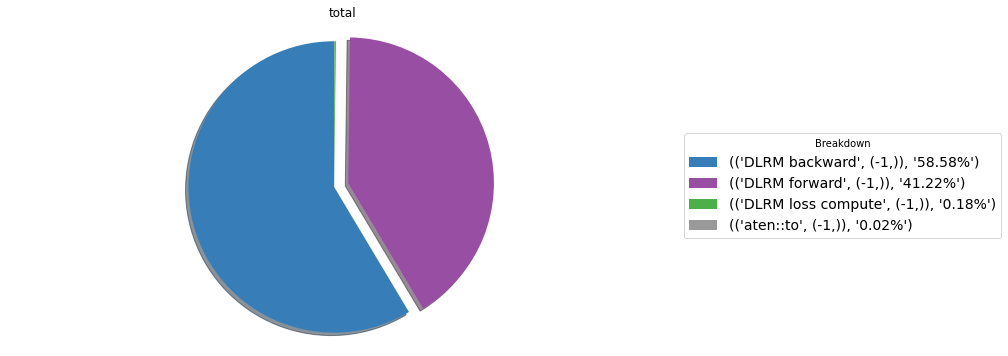

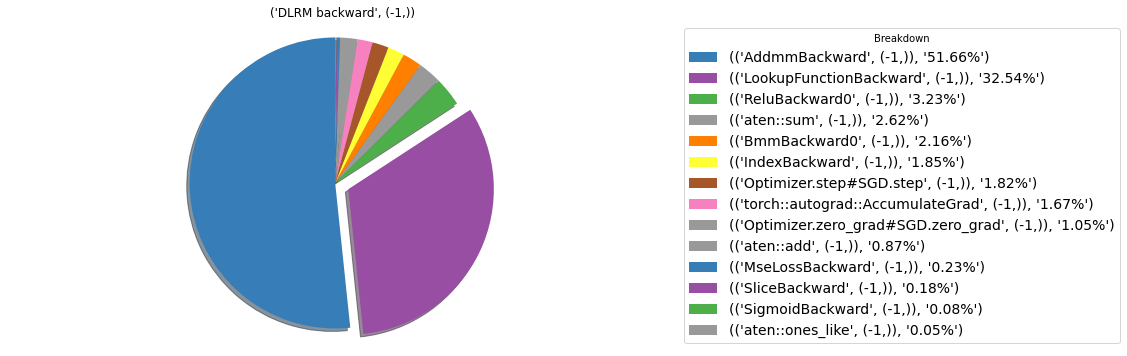

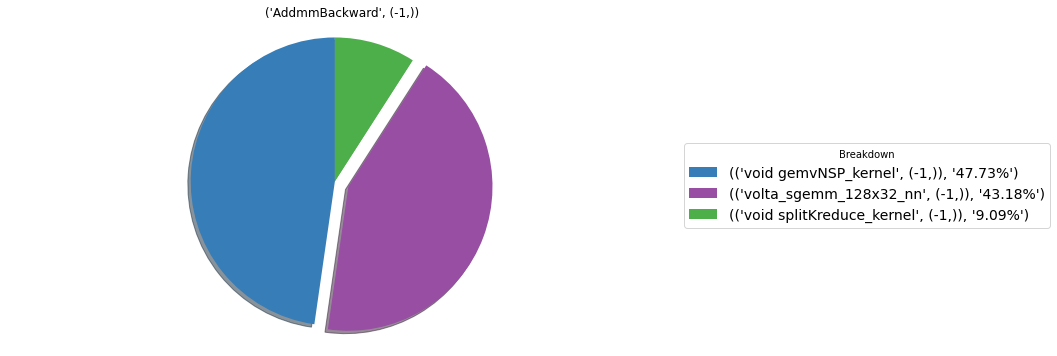

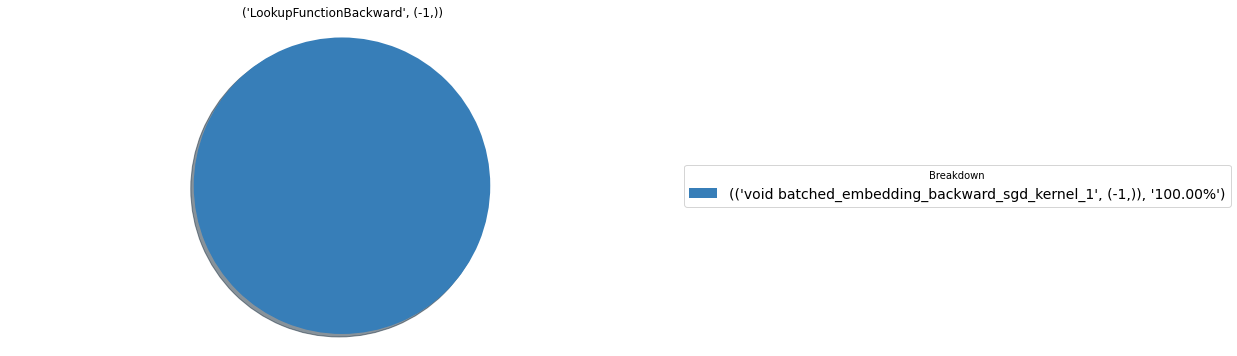

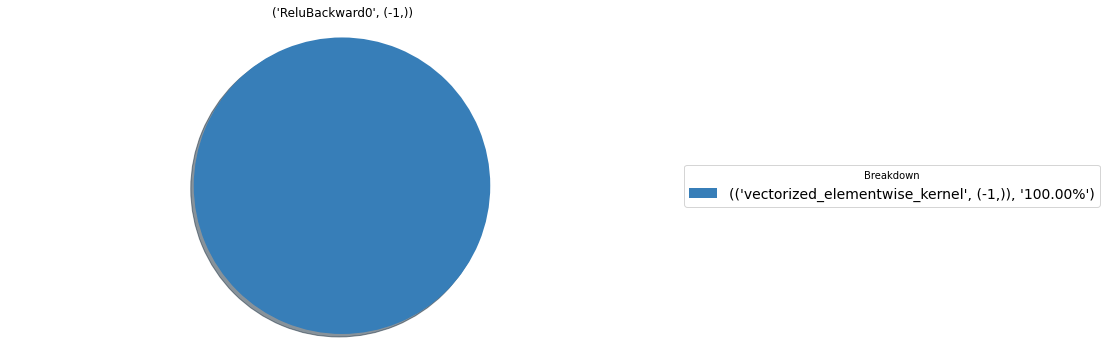

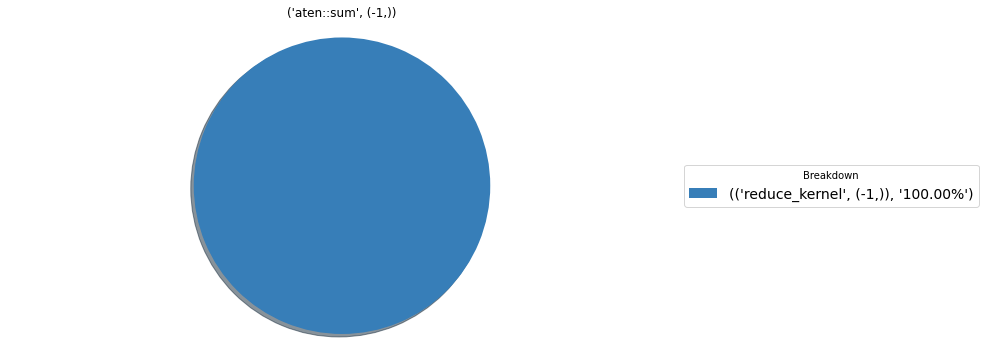

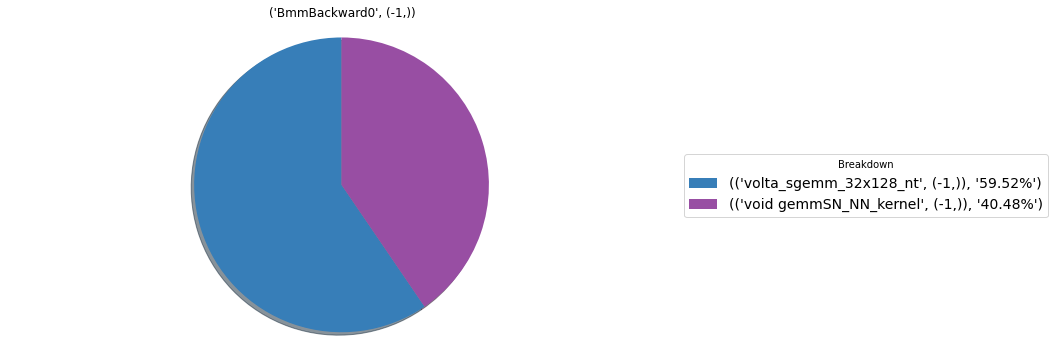

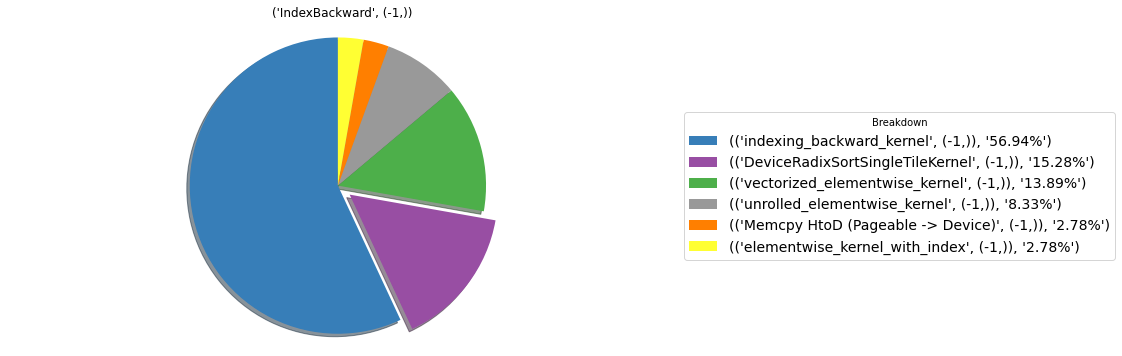

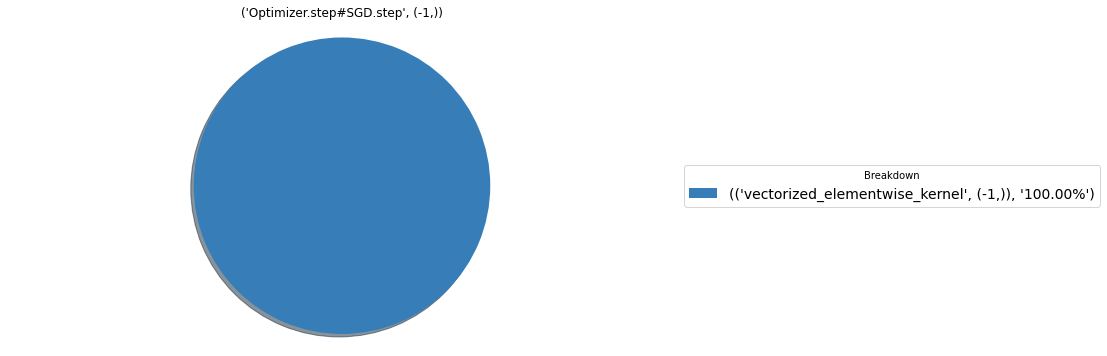

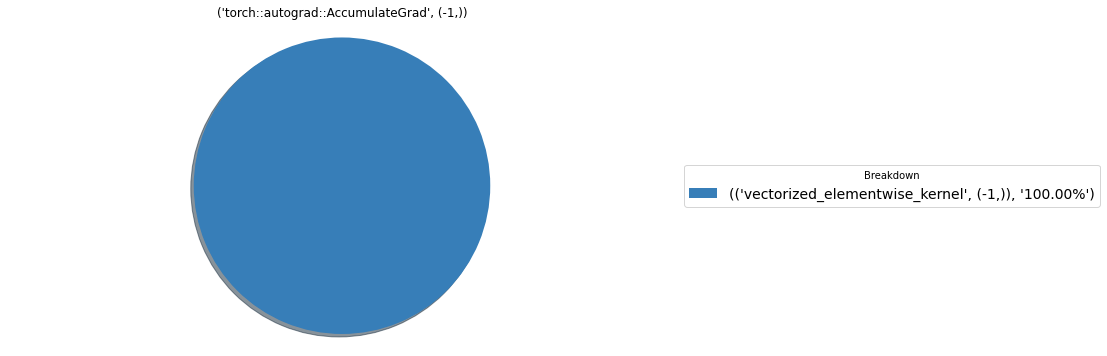

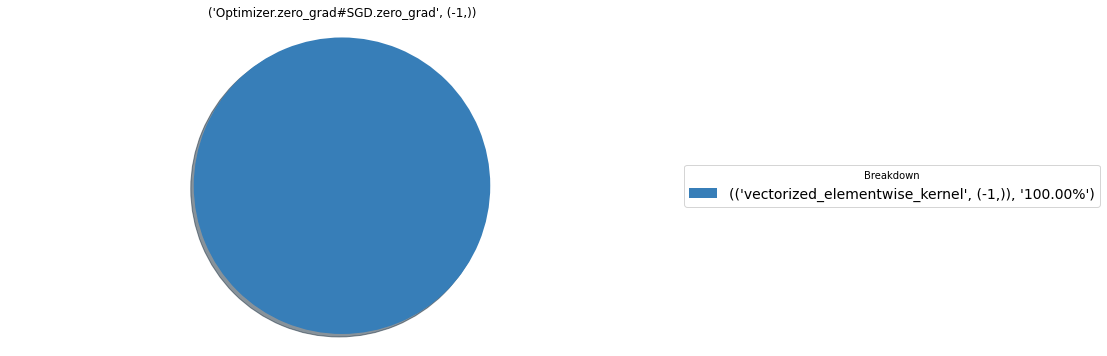

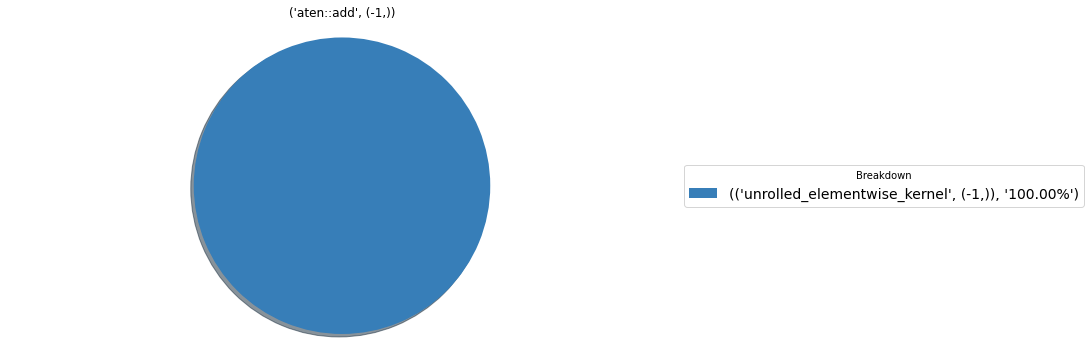

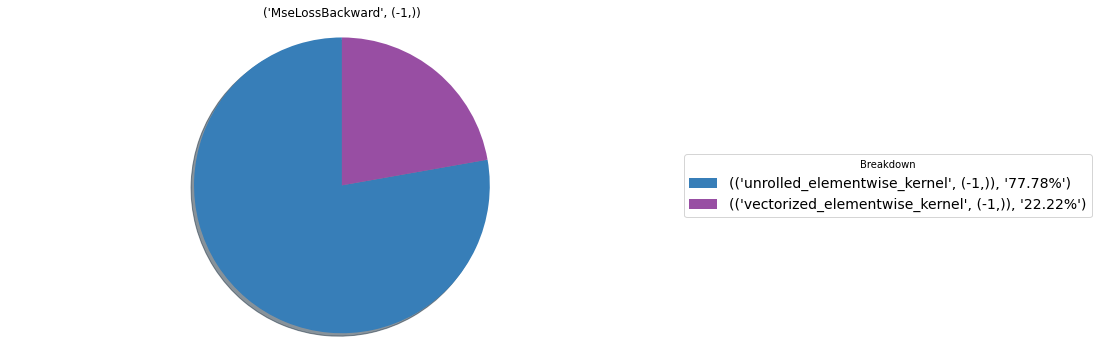

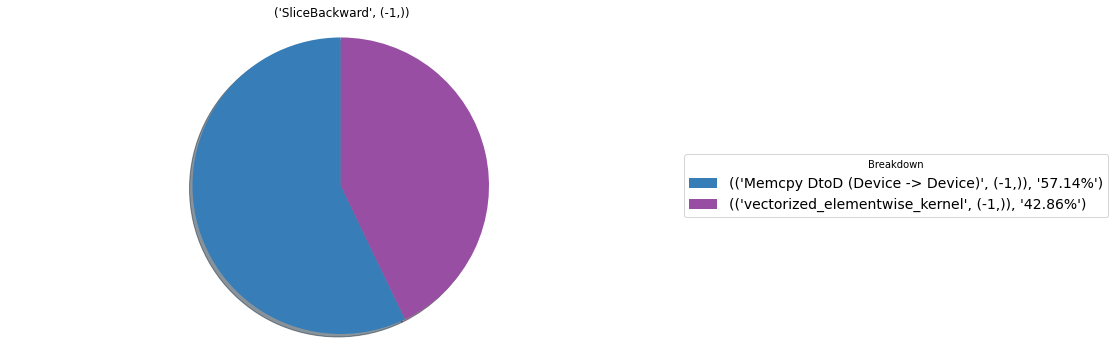

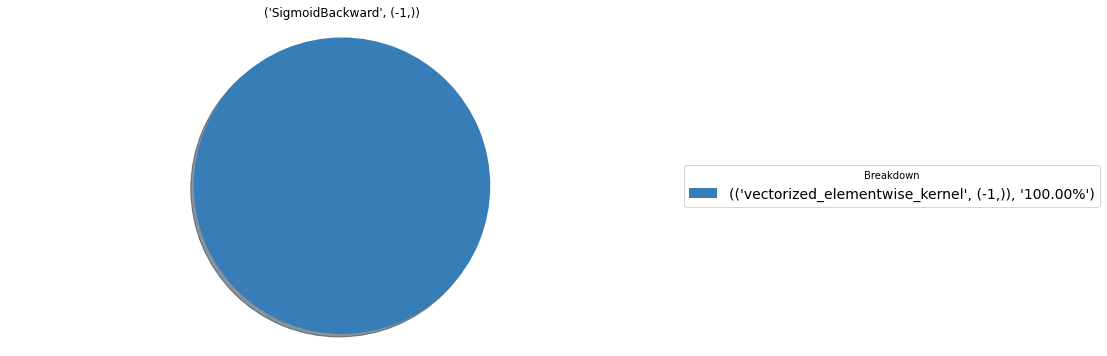

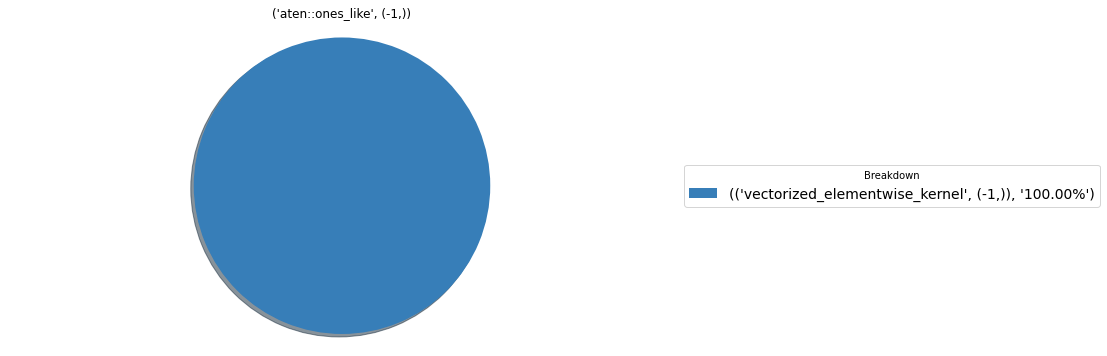

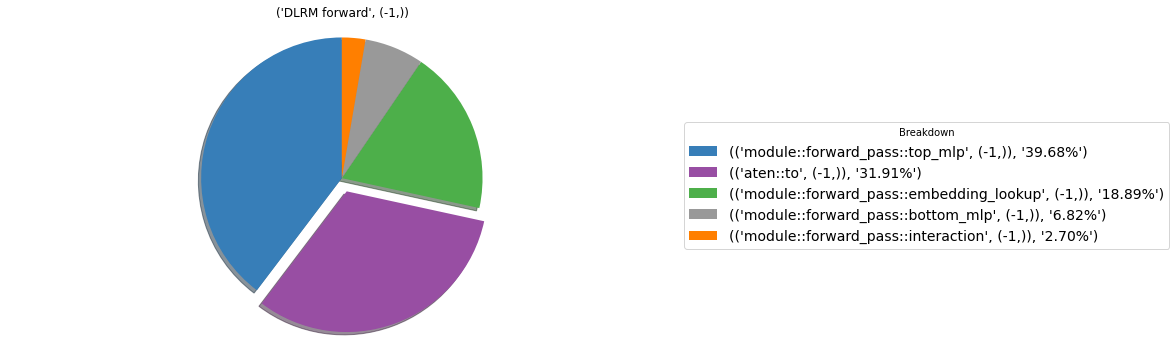

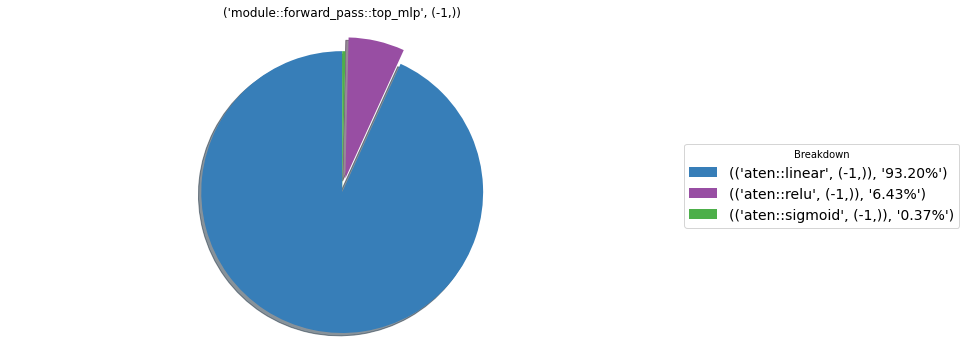

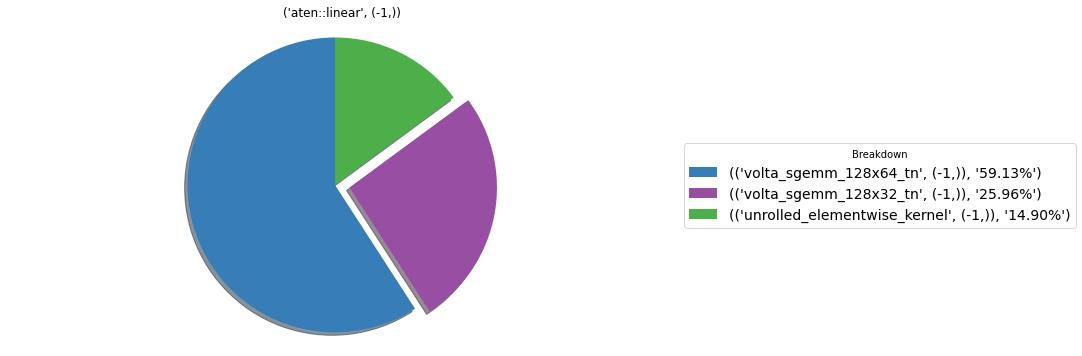

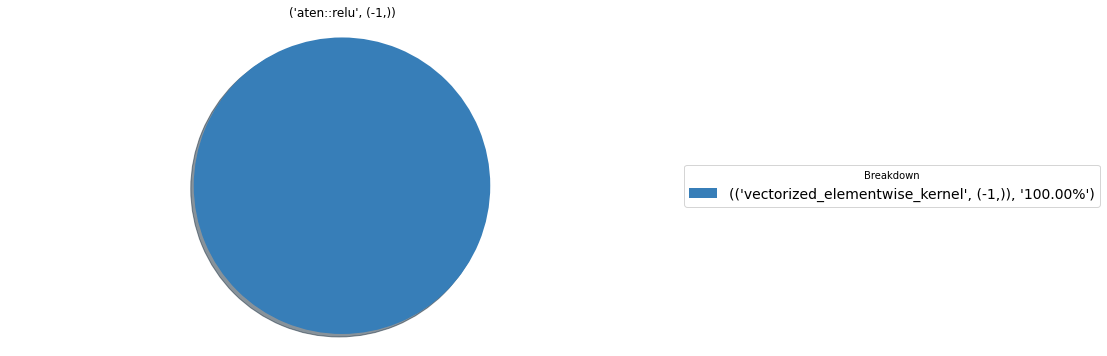

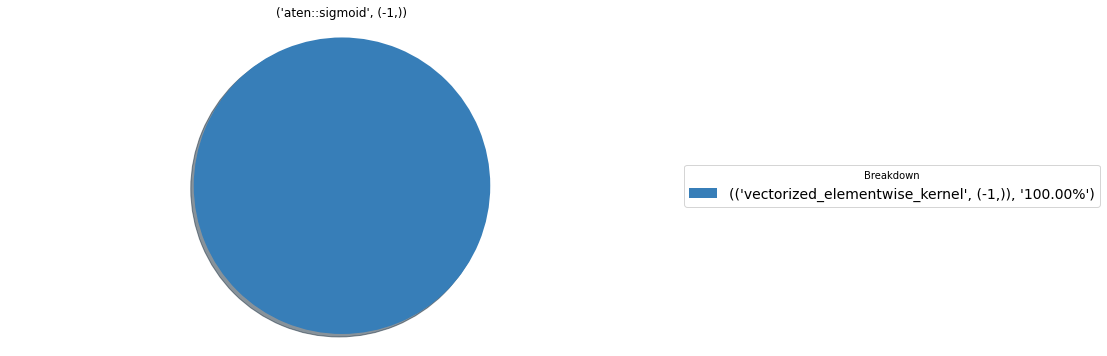

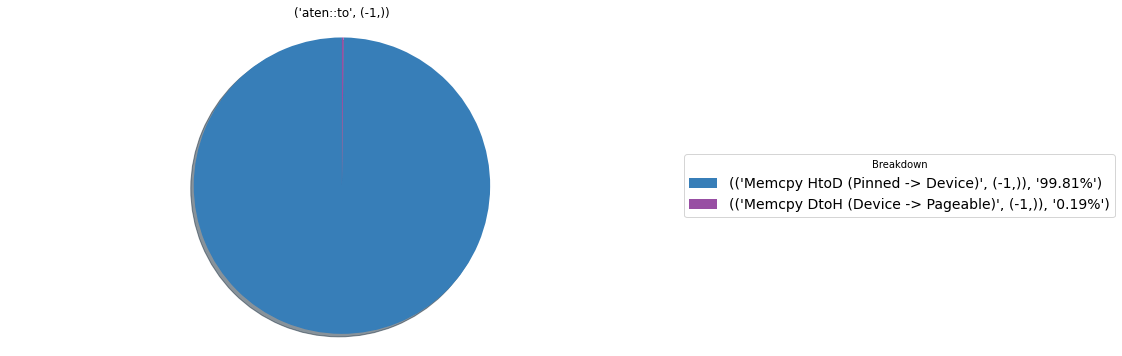

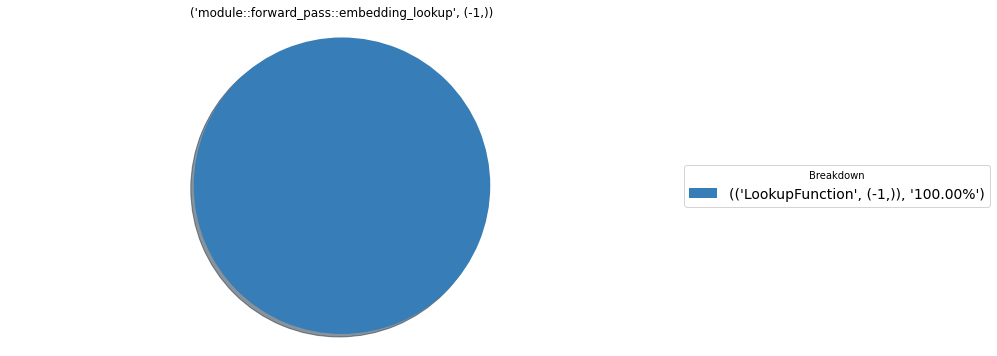

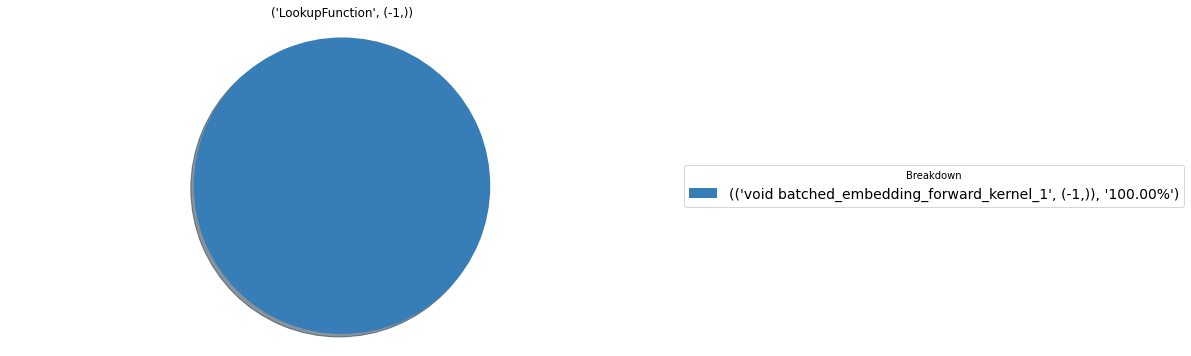

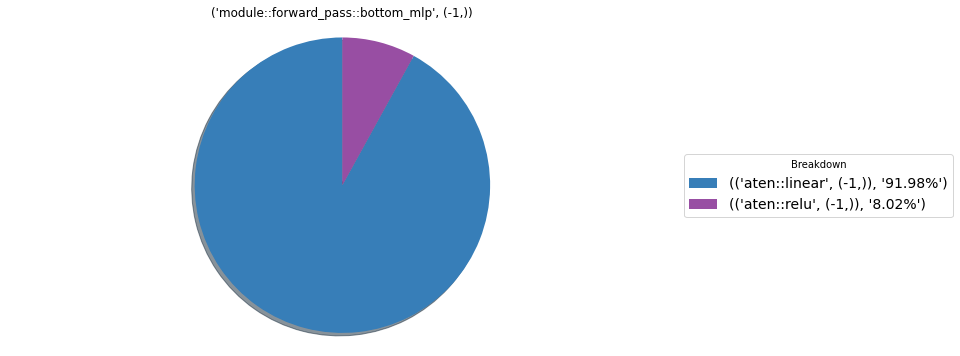

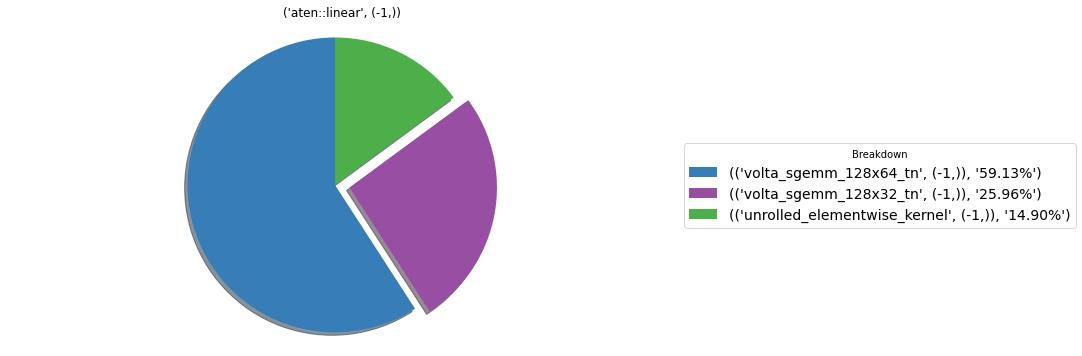

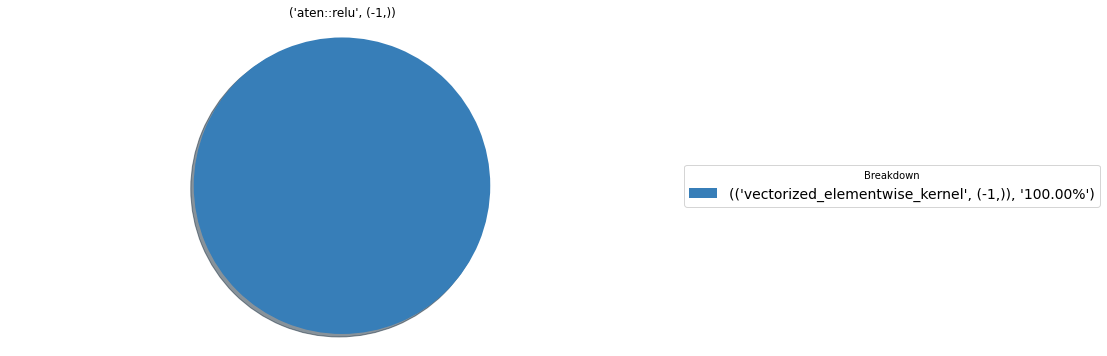

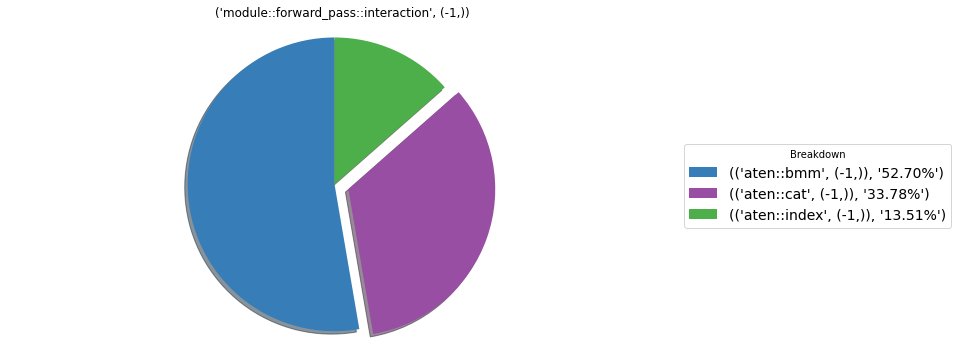

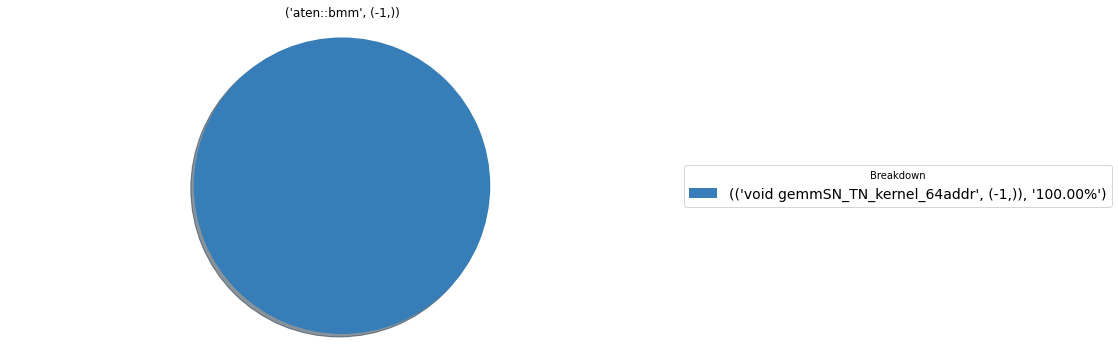

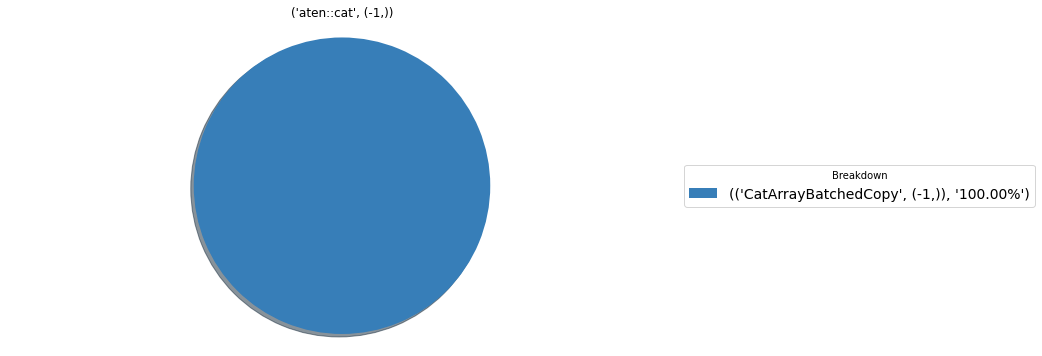

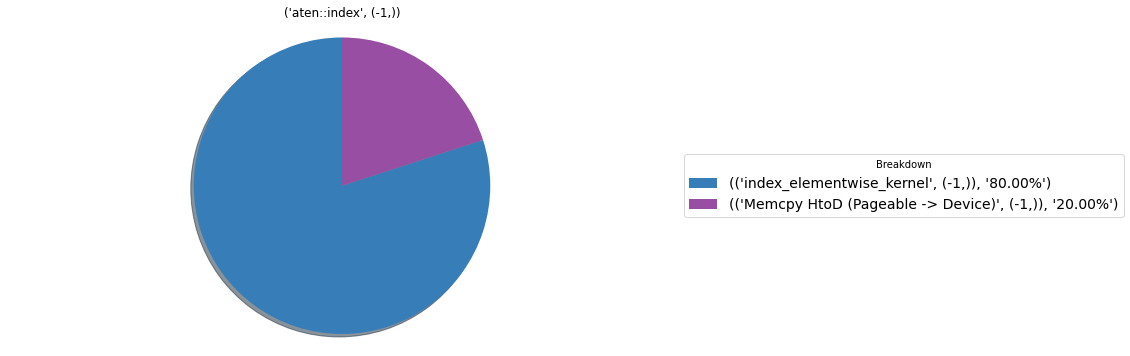

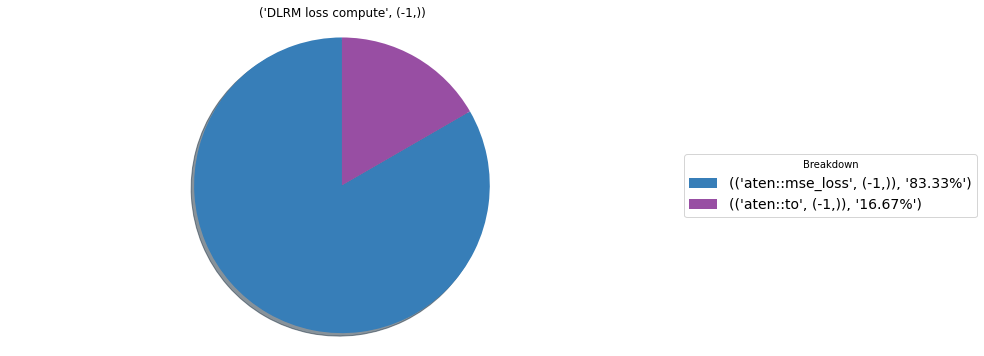

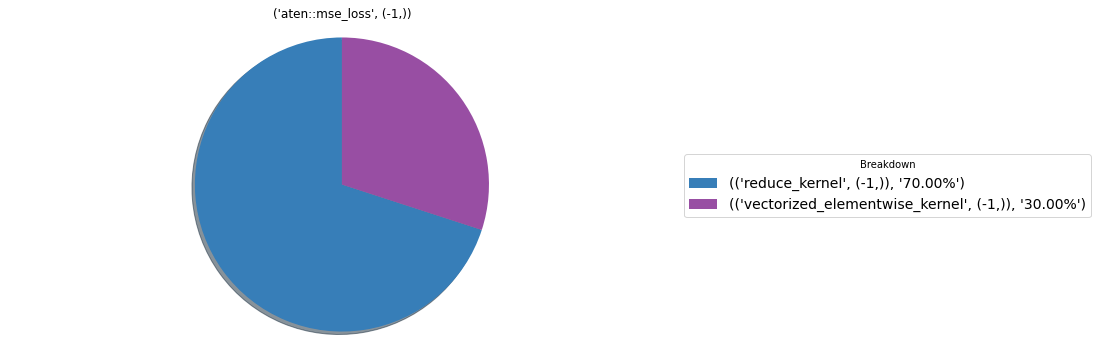

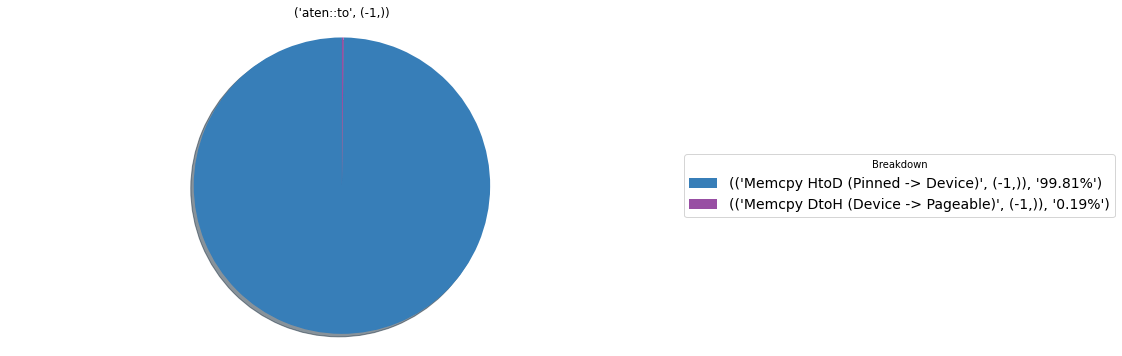

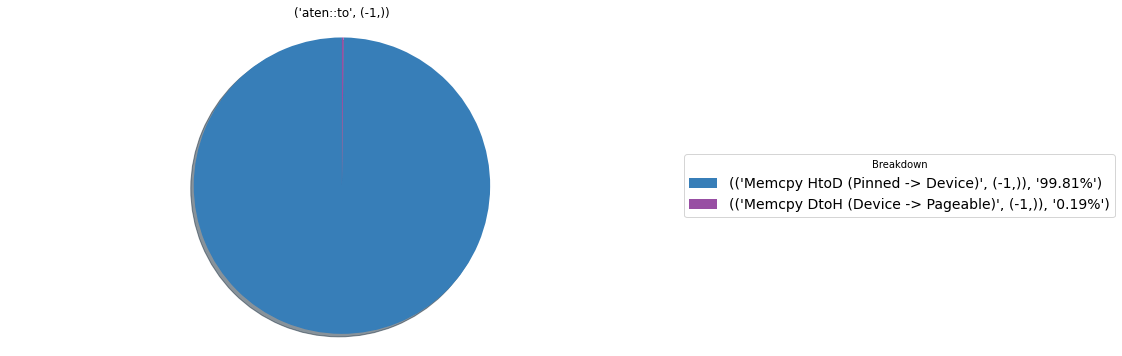

In [9]:
from matplotlib import cm
cs=cm.Set1([1, 3, 2, 25, 4, 5, 6, 7, 8, 11])

def plot_pie_chart(flatten, key="total", truncate_count=100, depth=0):
    d = flatten[key]
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    stats = sorted(d["subs"].items(), key=lambda x: x[1], reverse=True)
    labels = [x[0] for x in stats]
    runtime = [x[1] for x in stats]
    explode = np.zeros(len(runtime))
    if len(explode) > 2:
        explode[1] = 0.1

    fig1, ax1 = plt.subplots(figsize=(12, 6))
    wedges, texts = ax1.pie(runtime, explode=explode, shadow=True, startangle=90, colors=cs)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(key)
    
    ax1.legend(wedges, zip(labels, ["{:.2f}%".format(r / d["runtime"] * 100) for r in runtime]),
          title="Breakdown",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=14)
    
    for label in labels:
        if label in flatten:
            plot_pie_chart(flatten, key=label, truncate_count=truncate_count, depth=depth+1)

    if depth == 0:
        plt.show()

for stream, v in flatten.items():
    print("########################")
    print("STREAM: {}".format(stream))
    print("########################")
    plot_pie_chart(v, truncate_count=truncate_count)

########################
STREAM: 7
########################
66587.0


/home/m092926/.conda/envs/zhongyi/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/m092926/.conda/envs/zhongyi/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/m092926/.conda/envs/zhongyi/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


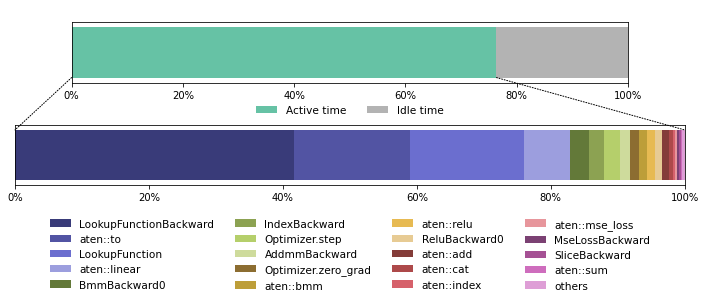

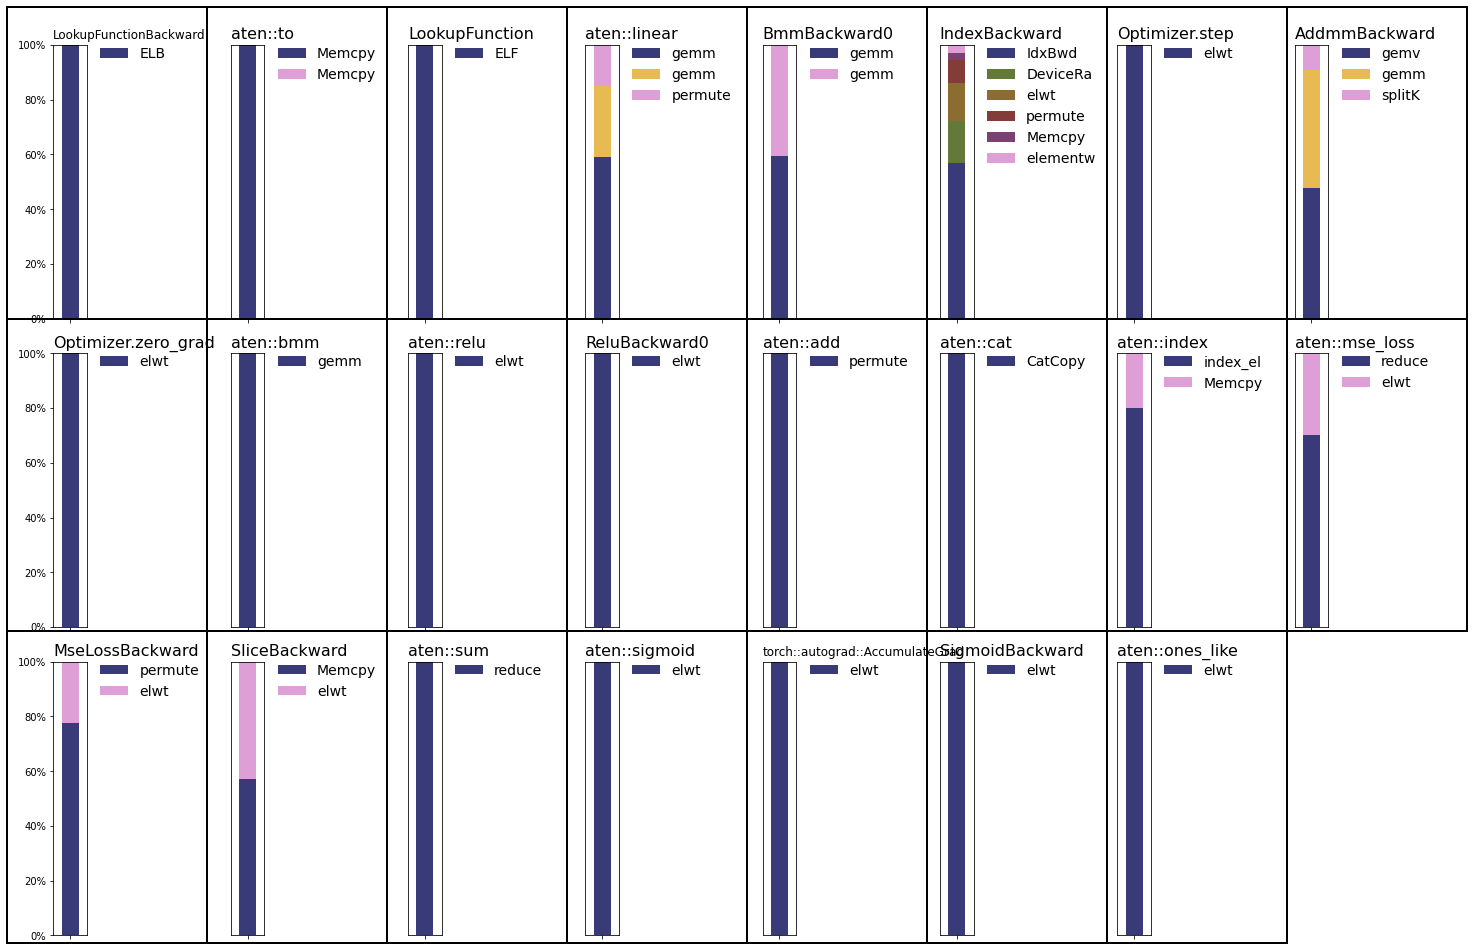

In [10]:
def kernel_name_to_legend(name):
    if 'gemm' in name:
        return 'gemm'
    if 'gemv' in name:
        return 'gemv'
    if 'Memset' in name:
        return 'Memset'
    if 'Memcpy' in name:
        return 'Memcpy'
    if 'vectorized_elementwise' in name:
        return 'elwt'
    if 'unrolled_elementwise' in name:
        return 'permute'
    if 'embedding_forward' in name:
        return 'ELF'
    if 'embedding_backward' in name:
        return 'ELB'
    if 'splitK' in name:
        return 'splitK'
    if 'reduce_kernel' in name:
        return 'reduce'
    if 'CatArray' in name:
        return 'CatCopy'
    if 'indexing' in name:
        return 'IdxBwd'
    return name[:8]

runtime_no_pf = -1
log_file = "{}/data/{}/e2e/{}/{}_{}.log".format(PM_HOME, GPU_NAME, model_name, num_gpus, batch_size)
if os.path.exists(log_file):
    for line in open(log_file, 'r'):
        if re.search("Overall per-batch", line):
            runtime_no_pf = float(line.split(' ')[4]) * 1000 * iters # us

def plot_bar_chart(flatten, key="total", truncate_count=100, depth=0):
    per_op = {}
    total = 0.0
    for k, v in flatten.items():
        if k == 'total' or 'DLRM ' in k[0] or 'module' in k[0]: # Skip all labels
            continue
        k0 = k[0] if '#' not in k[0] else k[0].split('#')[0]
        if k0 not in per_op.keys():
            per_op[k0] = 0.0
        per_op[k0] += v['runtime']
        total += v['runtime']
        
    tmp = sorted(per_op.items(), key=lambda x: x[1], reverse=True)
    op = [x[0] for x in tmp]
    p = [x[1] / total for x in tmp]
    print(flatten['total']['runtime'])
    df0 = pd.DataFrame({
        'Active time': [flatten['total']['runtime'] / runtime_no_pf],
        'Idle time': [1 - flatten['total']['runtime'] / runtime_no_pf]
    })
    if len(p) > 20:
        p[19] = sum(p[19:])
        p = p[:20]
        op[19] = "others"
        op = op[:20]
    df = pd.DataFrame([p], columns=op)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 3))
    axes[0] = plt.subplot2grid(shape=(2, 12), loc=(0, 1), colspan=10) # Uneven sizes of subplots
    axes[1] = plt.subplot2grid(shape=(2, 12), loc=(1, 0), colspan=12)

    ax0 = df0.plot(stacked=True, title=" ", kind='barh', width=0.05, ax=axes[0], cmap='Set2')
    vals = ax0.get_xticks()
    ax0.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    ax0.set_xlim((0.0, 1.0))
    ax0.set_yticks([])
    ax0.set_yticklabels([])
    ax0.set_ylim((-0.03, 0.03))
    ax0.legend(loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.7), frameon=False, fontsize=10.5)
    
    ax1 = df.plot(stacked=True, kind='barh', width=0.05, ax=axes[1], cmap='tab20b') # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    vals = ax1.get_xticks()
    ax1.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    ax1.set_xlim((0.0, 1.0))
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax1.set_ylim((-0.03, 0.03))
    ax1.legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, -1.9), frameon=False, fontsize=10.5)
    
    # Space between subplots
    plt.subplots_adjust(hspace=0.7)
    
    # Lines across subplots
    con1 = ConnectionPatch(xyA=(0,-0.025), xyB=(0,0.025), coordsA="data", coordsB="data", axesA=ax0, axesB=ax1, linestyle='dotted')
    con2 = ConnectionPatch(xyA=(flatten['total']['runtime'] / runtime_no_pf,-0.025), xyB=(1,0.025), coordsA="data", coordsB="data", axesA=ax0, axesB=ax1, linestyle='dotted')
    ax1.add_artist(con1)
    ax1.add_artist(con2)

    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [12, 3]
    plt.savefig('{}/data/{}/e2e/{}/active_time_breakdown.pdf'.format(PM_HOME, GPU_NAME, model_name), bbox_inches='tight')
    plt.savefig('{}/data/{}/e2e/{}/active_time_breakdown.png'.format(PM_HOME, GPU_NAME, model_name), bbox_inches='tight')
    
    t = {}
    for k, v in flatten.items():
        if k == 'total' or 'DLRM ' in k[0] or 'module' in k[0]: # Skip all labels
            continue
        k0 = k[0] if '#' not in k[0] else k[0].split('#')[0]
        if k0 not in t.keys(): # Per Op
            t[k0] = []
        a = {}
        total = 0.0
        for kk, vv in v['subs'].items():
            a[kk] = vv
            total += vv
        a = {x: y / total for x, y in a.items()}
        t[k0].append(a)
    so = sorted(t.items(), key=lambda x: per_op[x if isinstance(x, str) else x[0]], reverse=True)
    pprint([len(s[1]) for s in so])
    so = [list(x) for x in so]

    for s in so:
        keys = set()
        to_be_deleted = []
        # Find duplicate kernel combinations
        for idx, b in enumerate(s[1]):
            k = []
            for x in b.keys():
                if 'volta_sgemm' in x[0]:
                    xx = 'volta_sgemm'
                elif 'maxwell_sgemm' in x[0]:
                    xx = 'maxwell_sgemm'
                elif isinstance(x, str):
                    xx = x
                else:
                    xx = x[0]
                k.append(xx)
            k = tuple(sorted(k))
            if k in keys:
                to_be_deleted.append(idx)
            else:
                keys.add(k)
        # Delete duplicate kernel combinations
        for idx in sorted(to_be_deleted, reverse=True):
            del s[1][idx]
    pprint([len(s[1]) for s in so])

    nrows, ncols = 3, 8
    fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(20, 13))
    xx, yy = 0, 0
    rects, texts = [], []
    for s in so:
        num_variants = len(s[1])
        for idx, b in enumerate(s[1]):
            ax = plt.subplot(nrows, ncols, 1+xx+idx+yy*ncols)
            p = sorted(b.items(), key=lambda x: x[1], reverse=True)
            kernel_name = [kernel_name_to_legend(x[0] if isinstance(x[0], str) else x[0][0]) for x in p]
            perc = [x[1] for x in p]
            df = pd.DataFrame([perc], columns=kernel_name)
            _ = df.plot(stacked=True, kind='bar', ax=ax, cmap='tab20b')
            ax.get_legend().remove()
            if xx+idx == 0:
                ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
                ax.set_yticklabels(['{:,.0%}'.format(x) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
            else:
                ax.set_yticks([])
                ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_ylim((0.0, 1.0))
            ax.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left', frameon=False, fontsize=14)
            if idx == (len(s[1]) - 1) / 2:
                ax.set_title(s[0], loc='left', fontsize=(16 if len(s[0]) < 20 else 12))
            
        # Borders
        llc_x = 1.0 / ncols * (xx) + (0.014 if xx != 0 else 0)
        llc_y = 1.0 / nrows * (nrows-yy-1) + 0.01
        rx = 1.0 / ncols * (num_variants) + (0.014 if xx == 0 else 0)
        ry = 1.0 / nrows
        rects.append(plt.Rectangle(
            (llc_x, llc_y), rx, ry, fill=False, color="k", lw=2, zorder=1000, transform=fig.transFigure, figure=fig
        ))

        # Subplot position
        xx += num_variants
        if xx >= ncols:
            xx = 0
            yy += 1

    # Hardcoded for now
    axes[2,7].set_axis_off()
    
    fig.patches.extend(rects)
    plt.tight_layout()
    plt.rcParams['figure.figsize'] = [20, 13]
    plt.savefig('{}/data/{}/e2e/{}/dominating_op_breakdown.pdf'.format(PM_HOME, GPU_NAME, model_name), bbox_inches='tight')
    plt.savefig('{}/data/{}/e2e/{}/dominating_op_breakdown.png'.format(PM_HOME, GPU_NAME, model_name), bbox_inches='tight')

for stream, v in flatten.items():
    print("########################")
    print("STREAM: {}".format(stream))
    print("########################")
    plot_bar_chart(v, truncate_count=truncate_count)

In [11]:
# Type 1 overhead: between two op calls
# Type 2 overhead: before the first device call, op-specific
# Type 3 overhead: after the last device call, op-specific
# Type 4 overhead: kernel launches themselves, kernel-launch-type-specific
# Type 5 overhead: sum of gaps between kernel launches, op-specific
overheads = {'independent': {}}
overheads['independent']['t1'] = [] # Independent from names
overheads['independent']['t4'] = {} # Independent from names
launches_dict = {}

for i, op in enumerate(ops):
    name = op.name()
    if name not in overheads.keys():
        overheads[name] = {}

    if 't2' not in overheads[name].keys():
        overheads[name]['t2'] = []
    if 't3' not in overheads[name].keys():
        overheads[name]['t3'] = []
    if 't5' not in overheads[name].keys():
        overheads[name]['t5'] = []

    sub_event_count = get_sub_event_count(op)
    # Get the number of events before each kernel launch (to subtract corresponding amount of CPU overheads from estimated time)
    tmp_launches = get_event_all_kernel_launches(op)
    launches = []
    count = 0
    for x, y in tmp_launches:
        count += y
        if x.name() in ["cudaMemcpyAsync", "cudaLaunchKernel"]:
            launches.append((x, count))
            count = 0

    if len(launches) > 0:
        overheads[name]['t2'].append(launches[0][0].start_time() - op.start_time() - launches[0][1] * CPU_EVENT_OVERHEAD) # T2 has all overheads before the first launch
        trailing_sub_event_count = sub_event_count - sum([y+1 for _, y in launches]) # And kernel launches themselves
        overheads[name]['t3'].append(op.end_time() - launches[-1][0].end_time() - trailing_sub_event_count * CPU_EVENT_OVERHEAD) # T3 has all overheads after the last launch
        if len(launches) > 1:
            overheads[name]['t5'].extend([launches[i][0].start_time() - launches[i-1][0].end_time() - launches[i][1] * CPU_EVENT_OVERHEAD for i in range(1, len(launches))]) # T5 has all overheads between each pair of launches
        else:
            overheads[name]['t5'].append(0)

        # T4 is launch-type-dependent
        for x, _ in launches:
            if x.name() not in overheads['independent']['t4']:
                overheads['independent']['t4'][x.name()] = []
            overheads['independent']['t4'][x.name()].append(KERNEL_LAUNCH_LENGTH - CPU_EVENT_OVERHEAD - GPU_EVENT_OVERHEAD) # T4 has 1 overhead

        if op.name() not in launches_dict.keys():
            launches_dict[op.name()] = []
            for x, _ in launches:
                launches_dict[op.name()].append(x.name())
    else:
        if name not in overheads.keys():
            overheads[name] = {}
        # If an op doesn't have kernel calls it has only one T5 overhead representing its CPU duration
        if 't5' not in overheads[name].keys():
            overheads[name]['t5'] = []
        if name == "aten::to":
            continue # Some aten::to doesn't have children
        else:
            overheads[name]['t5'].append(op.duration() - sub_event_count * CPU_EVENT_OVERHEAD) # Remove cpu overhead for all sub events

    if i > 0:
        prev_op = ops[i-1]

        # Only consider adjacent ops under the SAME MODULE
        if prev_op.parent != op.parent:
            continue

        gap = op.start_time() - prev_op.end_time()
        if gap < 200: # Skip dataloading gaps
            overheads['independent']['t1'].append(gap - CPU_EVENT_OVERHEAD) # Some pairs of ops are actually inserted by a runtime call which has been filtered from ops. TODO: fix it.

# # T1: mean ~= 21, std ~= 20
# from analysis.utils import histogram
# histogram(overheads['independent']['t1'], perc=False, bins=[0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 200, 100000])
# print(np.mean(overheads['independent']['t1']), np.std(overheads['independent']['t1']))

# T2, T3, T5
t2 = {k: (np.mean(v['t2']), np.std(v['t2'])) for k, v in overheads.items() if k != 'independent' and len(v['t2']) > 0}
# pprint(t2)
t3 = {k: (np.mean(v['t3']), np.std(v['t3'])) for k, v in overheads.items() if k != 'independent' and len(v['t3']) > 0}
# pprint(t3)
t5 = {k: (np.mean(v['t5']), np.std(v['t5'])) for k, v in overheads.items() if k != 'independent' and len(v['t5']) > 0}
# pprint(t5)

# # T4
# for t, l in overheads['independent']['t4'].items():
#     print(t, np.mean(l), np.std(l))

o = {
    "t1": (np.mean(overheads['independent']['t1']), np.std(overheads['independent']['t1'])),
    "t2": t2,
    "t3": t3,
    "t4": {
        t: (np.mean(l), np.std(l)) for t, l in overheads['independent']['t4'].items()
    },
    "t5": t5,
    "launches": launches_dict
}

# with open("overheads_{}.json".format(model_name), "w") as f:
#     json.dump(o, f)

### Multistream analysis

In [12]:
# # Not finished yet
# all_kernels = []
# for _, c in cc.items():
#     for _, v in c["callees"].items():
#         if v["executor"] is not None:
#             all_kernels.append(v["executor"])
# all_kernels = sorted(all_kernels, key=lambda x: x.start_time())

# idle_time = 0
# last_end = all_kernels[0].start_time() + all_kernels[0].duration()
# overlapped = 0
# for k in all_kernels:
#     if k.start_time() > last_end:
#         idle_time += k.start_time() - last_end
#         last_end = k.start_time() + k.duration()
#     else:
#         last_end = max(last_end, k.start_time() + k.duration())
#         overlapped += min(last_end, k.start_time() + k.duration()) - k.start_time()

# print("device_runtime", device_runtime)
# print("idle_time:", idle_time)
# print("overlapped_time", overlapped)